In [ ]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree

from sklearn.model_selection import cross_val_score, KFold

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
movies = pd.read_csv('movies.csv')

In [ ]:
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...,/qnqGbB22YJ7dSs4o6M7exTpNxPz.jpg,/m8JTwHFwX7I7JY5fPe4SjqejWag.jpg,823999-676841-868759-734048-267805-965839-1033...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...,/cvsXj3I9Q2iyyIo95AecSd1tad7.jpg,/5i6SjyDbDWqyun8klUuCxrlFbyw.jpg,965839-267805-943822-842942-1035806-823999-107...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722636,282567,Shriasthu Shubhamasthu,Romance,en,Shriasthu Shubhamasthu is a 2000 Kannada film ...,0.600,NaN,2000-08-10,0.0,0.0,NaN,Released,NaN,0.000,0.0,Ramesh Aravind-Anu Prabhakar-Srinivasa Murthy-...,NaN,NaN,NaN,NaN
722637,707918,Winter Lake,Documentary-Family,fi,“My friends can’t believe I go camping in wint...,0.600,Citizen Jane Productions,2020-05-19,0.0,0.0,15.0,Released,NaN,0.000,0.0,Antti Saario-Emika Saario,NaN,/nUXEZOaKxwqzh3V1FqZOesYsjmm.jpg,NaN,NaN
722638,693301,Pil og bue,Drama-Documentary,no,There is an equestrian center in the north of ...,0.600,NaN,2016-09-20,0.0,0.0,64.0,Released,NaN,0.000,0.0,Anna Katharina Haukeland,NaN,NaN,NaN,NaN
722639,765960,Pudesse Ser Apenas Um Enigma,Documentary,pt,NaN,0.600,NaN,NaN,0.0,0.0,0.0,Released,NaN,0.000,0.0,Jéssica Teixeira-Ariel Volkova,theater play,NaN,NaN,NaN


In [ ]:
#DATA CLEANUP
#Get all the released movies 
movies = movies[movies['status'] == 'Released']

#Get all the movies between January 2000 to August 2023
movies = movies[(movies['release_date'] >= '2000-01-01') & (movies['release_date'] <= '2023-08-31')]

#Get all movies that have English as original language?? 
#Might be easier to build model and predict revenue if we eliminate disparties that could come from diff countries
# Purbasha - I agree with the satement above 
movies = movies[movies['original_language'] == 'en']

#Off the bat these columns seem pretty useless so deleting them
movies = movies.drop(['poster_path', 'backdrop_path', 'recommendations'], axis=1)

#Drop null runtime
movies = movies[(movies['runtime'].isnull()) == False]

movies = movies[movies['revenue'] != 0]

movies.shape

(6941, 17)

In [ ]:
movies = movies[movies['genres'].isnull() == False]
#change cast to list of strings with top 5 actors in movie
movies['credits'] = movies['credits'].str.split('-')
movies = movies[movies['credits'].isnull() == False]
movies['credits'] = movies['credits'].apply(lambda top_5: top_5[:8])
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,"[Jason Statham, Wu Jing, Shuya Sophia Cai, Ser...",based on novel or book-sequel-kaiju
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,"[Russell Crowe, Daniel Zovatto, Alex Essoe, Fr...",spain-rome italy-vatican-pope-pig-possession-c...
2,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,"[Anthony Ramos, Dominique Fishback, Luna Laure...",peru-alien-end of the world-based on cartoon-b...
3,640146,Ant-Man and the Wasp: Quantumania,Action-Adventure-Science Fiction,en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,"[Paul Rudd, Evangeline Lilly, Jonathan Majors,...",hero-ant-sequel-superhero-based on comic-famil...
4,677179,Creed III,Drama-Action,en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,"[Michael B. Jordan, Tessa Thompson, Jonathan M...",philadelphia pennsylvania-husband wife relatio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718832,852850,Witch Graveyard,Horror-Fantasy,en,Four travelers innocently decide to rest in a ...,0.600,NaN,2013-06-14,0.0,9554.0,70.0,Released,NaN,0.000,0.0,"[Catherine Franklin, Reuben Rox, Rachel Wise, ...",NaN
720628,839835,Thiruvalar Panchankam,Drama-Documentary-Animation,en,The film revolves around Karthik (Ananth Nag) ...,0.600,Alar studios,2020-12-11,1.0,1.0,113.0,Released,NaN,0.000,0.0,"[Ananth Nag, Kadhal Sukumar, Adukalam Naren, U...",NaN
721742,758247,Zimmedari - A Responsibility,Drama-Documentary,en,This Film Reminds people to Remember their Res...,0.600,MD Arts Productions Co.,2019-04-25,0.0,1000.0,4.0,Released,Voting is not a right it's a responsibility.,0.000,0.0,"[Ashish Dubey, Ravi Jadhav, Rajesh sharma, Nir...",educational
722275,853631,A Way Out,Drama,en,NaN,0.600,Blushot,2021-04-12,1.0,1.0,7.0,Released,NaN,9.000,1.0,[Anas Alhajj],experimental narrative


<AxesSubplot: >

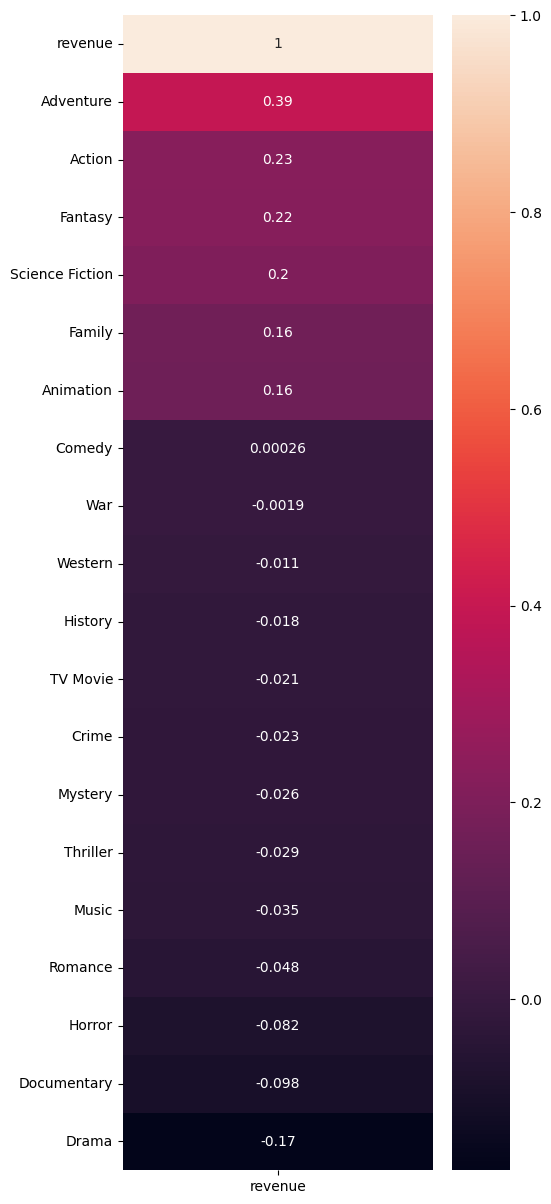

In [ ]:
#Correlation between genre and revenue
genres = movies['genres'].str.split('-')
genres_ohe = pd.get_dummies(genres.apply(pd.Series).stack()).groupby(level=0).sum()
genres_ohe["revenue"] = movies["revenue"]
correlation = genres_ohe.corr()
correlation = pd.DataFrame(correlation.loc[:,"revenue"]).sort_values(by = "revenue", ascending=False)
fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(correlation, annot=True)

In [ ]:
movies['genres'] = movies['genres'].str.split('-')
#movies['genres'].apply(pd.Series).stack().to_frame()
genres_ohe = movies[['title', 'genres']].explode('genres').pivot_table(index='title', columns='genres', aggfunc=len, fill_value=0).reset_index()
movies = pd.merge(movies, genres_ohe, on='title')
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,615656,Meg 2: The Trench,"[Action, Science Fiction, Horror]",en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,...,0,1,0,0,0,1,0,0,0,0
1,758323,The Pope's Exorcist,"[Horror, Mystery, Thriller]",en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,...,0,1,0,1,0,0,0,1,0,0
2,667538,Transformers: Rise of the Beasts,"[Action, Adventure, Science Fiction]",en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,...,0,0,0,0,0,1,0,0,0,0
3,640146,Ant-Man and the Wasp: Quantumania,"[Action, Adventure, Science Fiction]",en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,...,0,0,0,0,0,1,0,0,0,0
4,677179,Creed III,"[Drama, Action]",en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,852850,Witch Graveyard,"[Horror, Fantasy]",en,Four travelers innocently decide to rest in a ...,0.600,NaN,2013-06-14,0.0,9554.0,...,0,1,0,0,0,0,0,0,0,0
6689,839835,Thiruvalar Panchankam,"[Drama, Documentary, Animation]",en,The film revolves around Karthik (Ananth Nag) ...,0.600,Alar studios,2020-12-11,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6690,758247,Zimmedari - A Responsibility,"[Drama, Documentary]",en,This Film Reminds people to Remember their Res...,0.600,MD Arts Productions Co.,2019-04-25,0.0,1000.0,...,0,0,0,0,0,0,0,0,0,0
6691,853631,A Way Out,[Drama],en,NaN,0.600,Blushot,2021-04-12,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
 #The amount of times the actors in each movie have appeared in other movies in the dataset
movies['actor_counts'] = pd.Series(len(movies))
num_credits = movies['credits'].explode().value_counts()
index = -1
for actors in movies['credits']:
   counts = 0
   index += 1
   for actor in range(len(actors)):
      counts += num_credits[actors[actor]]
   movies['actor_counts'].iloc[index] = counts

In [ ]:
movies

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,actor_counts
0,615656,Meg 2: The Trench,"[Action, Science Fiction, Horror]",en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,...,1,0,0,0,1,0,0,0,0,71.0
1,758323,The Pope's Exorcist,"[Horror, Mystery, Thriller]",en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,...,1,0,1,0,0,0,1,0,0,42.0
2,667538,Transformers: Rise of the Beasts,"[Action, Adventure, Science Fiction]",en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,...,0,0,0,0,1,0,0,0,0,16.0
3,640146,Ant-Man and the Wasp: Quantumania,"[Action, Adventure, Science Fiction]",en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,...,0,0,0,0,1,0,0,0,0,121.0
4,677179,Creed III,"[Drama, Action]",en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,...,0,0,0,0,0,0,0,0,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688,852850,Witch Graveyard,"[Horror, Fantasy]",en,Four travelers innocently decide to rest in a ...,0.600,NaN,2013-06-14,0.0,9554.0,...,1,0,0,0,0,0,0,0,0,8.0
6689,839835,Thiruvalar Panchankam,"[Drama, Documentary, Animation]",en,The film revolves around Karthik (Ananth Nag) ...,0.600,Alar studios,2020-12-11,1.0,1.0,...,0,0,0,0,0,0,0,0,0,4.0
6690,758247,Zimmedari - A Responsibility,"[Drama, Documentary]",en,This Film Reminds people to Remember their Res...,0.600,MD Arts Productions Co.,2019-04-25,0.0,1000.0,...,0,0,0,0,0,0,0,0,0,11.0
6691,853631,A Way Out,[Drama],en,NaN,0.600,Blushot,2021-04-12,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
#Find out whether a movie is in the top 15 production companies that have produced the most movies in the dataset
top_production_companies = movies['production_companies'].str.split('-').apply(pd.Series).stack()
top_15_production_companies = top_production_companies.value_counts()[0:15].reset_index()['index']
movies = movies[movies['production_companies'].isnull()==False]
movies['top_production'] = [sum(top_15_production_companies.isin(companies)) for companies in movies['production_companies'].str.split('-')]

<AxesSubplot: >

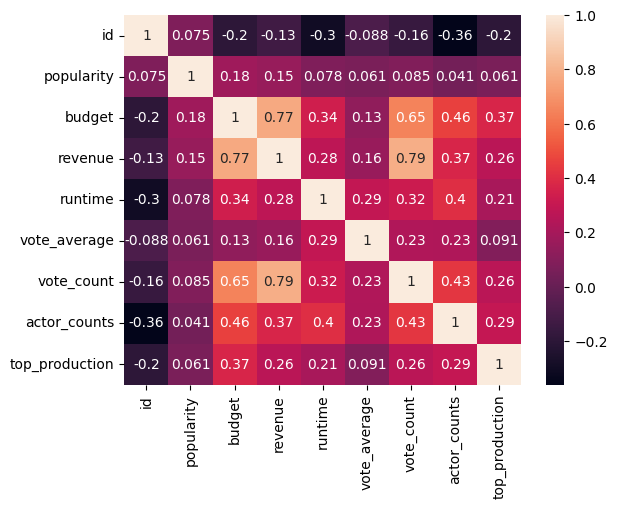

In [ ]:
#Correlation HeatMap
not_including_genres = movies.iloc[:,:16]
not_including_genres['actor_counts'] = movies['actor_counts']
not_including_genres['top_production'] = movies['top_production']
sns.heatmap(not_including_genres.corr(), annot=True)
# not_including_genres
#Looks like the best features to use is budget and vote_count, popularity could be significant, will need to do model selection for this

In [ ]:
not_including_genres

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,actor_counts,top_production
0,615656,Meg 2: The Trench,"[Action, Science Fiction, Horror]",en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,"[Jason Statham, Wu Jing, Shuya Sophia Cai, Ser...",71.0,1
1,758323,The Pope's Exorcist,"[Horror, Mystery, Thriller]",en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,"[Russell Crowe, Daniel Zovatto, Alex Essoe, Fr...",42.0,0
2,667538,Transformers: Rise of the Beasts,"[Action, Adventure, Science Fiction]",en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,"[Anthony Ramos, Dominique Fishback, Luna Laure...",16.0,1
3,640146,Ant-Man and the Wasp: Quantumania,"[Action, Adventure, Science Fiction]",en,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Marvel Studios-Kevin Feige Productions,2023-02-15,200000000.0,475766228.0,125.0,Released,Witness the beginning of a new dynasty.,6.507,2811.0,"[Paul Rudd, Evangeline Lilly, Jonathan Majors,...",121.0,0
4,677179,Creed III,"[Drama, Action]",en,After dominating the boxing world Adonis Creed...,3994.342,Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...,2023-03-01,75000000.0,269000000.0,116.0,Released,You can't run from your past.,7.262,1129.0,"[Michael B. Jordan, Tessa Thompson, Jonathan M...",40.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6684,772921,Requiem,[Comedy],en,Some neighbors come to the old woman's house a...,0.600,The Rebels Productions,2018-11-24,500.0,500.0,10.0,Released,Requiem,0.000,0.0,"[Mohammad Ali Gerami, Hadis Eftekhari, Aamin R...",6.0,0
6685,854916,Rejects,"[Action, Drama, Science Fiction]",en,Guns cash and four friends who have the wrong ...,0.600,Lab5 Films,2021-07-30,500.0,500.0,13.0,Released,"Guns, cash and four friends who have the wrong...",8.000,1.0,"[Honda King, Randall Walter McDonald, Austin B...",6.0,0
6689,839835,Thiruvalar Panchankam,"[Drama, Documentary, Animation]",en,The film revolves around Karthik (Ananth Nag) ...,0.600,Alar studios,2020-12-11,1.0,1.0,113.0,Released,NaN,0.000,0.0,"[Ananth Nag, Kadhal Sukumar, Adukalam Naren, U...",4.0,0
6690,758247,Zimmedari - A Responsibility,"[Drama, Documentary]",en,This Film Reminds people to Remember their Res...,0.600,MD Arts Productions Co.,2019-04-25,0.0,1000.0,4.0,Released,Voting is not a right it's a responsibility.,0.000,0.0,"[Ashish Dubey, Ravi Jadhav, Rajesh sharma, Nir...",11.0,0


In [ ]:
#neural network with original columns (not new ones)
#NOT FINAL MODEL
train = movies[["budget", "actor_counts", "vote_count"]]
test = movies[['revenue']]

reg = MLPRegressor(hidden_layer_sizes=(50, 50),
                    activation = 'relu',
                    alpha = 0.01,
                    solver = 'adam',
                    learning_rate = 'constant',
                    random_state=42)


X_train, X_test, Y_train, Y_test = train_test_split(train, test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler = StandardScaler()
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

reg.fit(X_train,Y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

print(mean_squared_error(y_pred_train, Y_train))
print(mean_squared_error(y_pred_test, Y_test))

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

scores = cross_val_score(reg, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')

for i, mse in enumerate(scores, 1):
    print(f'Fold {i}: Mean Squared Error: {abs(mse)}')

# Calculate and print the average mean squared error across all folds
average_mse = np.mean(np.abs(scores))
print(f'Average Mean Squared Error: {average_mse}')

#Model Beforehand
# 0.30124336999660867  Training Error 
# 0.4870818524853449   Testing Error 

#Model Now with Features  budget,and vote_count, actor_counts, maybe vote_average
#0.2428821651967478     Training Error 
#0.28656974330529505 ,  0.2404698363534221  Testing Error 

0.19742696090743378
0.19639348325512665
Fold 1: Mean Squared Error: 0.20071042685342677
Fold 2: Mean Squared Error: 0.32238083192934963
Fold 3: Mean Squared Error: 0.3255034224375418
Fold 4: Mean Squared Error: 0.2746980645854817
Fold 5: Mean Squared Error: 0.22077436447456295
Average Mean Squared Error: 0.2688134220560726


In [ ]:
#Best hyperparameters of neural network
param_grid = {
    'hidden_layer_sizes': [(10,), (50, 50)],
    'activation': ['logistic', 'relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],
}

grid_search = GridSearchCV(MLPRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
#random forest regression with original columns (not new ones)
#NOT FINAL MODEL
train = movies[["budget", "actor_counts", "vote_count"]]
test = movies[['revenue']]
rf_regressor = RandomForestRegressor(n_estimators=200, 
                                     random_state=42,
                                     max_depth = 20, 
                                     max_features = 'sqrt',
                                     min_samples_split = 10,
                                     min_samples_leaf = 2,
                                     bootstrap = True)


X_train, X_test, Y_train, Y_test = train_test_split(train, test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler = StandardScaler()
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

rf_regressor.fit(X_train,Y_train)
y_pred_train = rf_regressor.predict(X_train)
y_pred_test = rf_regressor.predict(X_test)

print(mean_squared_error(y_pred_train, Y_train))
print(mean_squared_error(y_pred_test, Y_test))

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

scores = cross_val_score(rf_regressor, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')

for i, mse in enumerate(scores, 1):
    print(f'Fold {i}: Mean Squared Error: {abs(mse)}')

# Calculate and print the average mean squared error across all folds
average_mse = np.mean(np.abs(scores))
print(f'Average Mean Squared Error: {average_mse}')

#Model Beforehand 
# 0.33843501058260034    Training Error
# 0.26570622177227976    Test Error 

#Model Now With Features budget,and vote_count, actor_counts, maybe vote_average
#0.24906712856055097     Training Error 
#0.22255791125691668, 0.19005597861286838    Testing Error 

0.13485687551548095
0.2679237962471759
Fold 1: Mean Squared Error: 0.2919915194715843
Fold 2: Mean Squared Error: 0.18008090017111078
Fold 3: Mean Squared Error: 0.17563956190354155
Fold 4: Mean Squared Error: 0.2552673045370985
Fold 5: Mean Squared Error: 0.3428788203848241
Average Mean Squared Error: 0.24917162129363185


In [ ]:
#Find best hyperparameters to random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 0.5],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'random_state': [42],
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}


In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Combining Ensemble Methods to get the best accuracy
#Combining Random Forest, Neural Network, and XGBoost with Stacking Regressor
#FINAL MODEL
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
train= movies[['Adventure', 'Action', 'Fantasy', 'Science Fiction', 'budget', 'vote_count', 'runtime', 'vote_average'
               ,'popularity', 'actor_counts', 'top_production', 'Family', 'Animation', 'Comedy']]
#train['budget'] = np.log(train['budget'])
#mean = np.log(movies['budget']).replace([np.inf, -np.inf], np.nan).mean()
#train['budget'] = movies['budget'].replace([np.nan, np.inf, -np.inf], mean)
test = np.log(movies[['revenue']])

X_train, X_test, Y_train, Y_test = train_test_split(train, test)

#scaler = StandardScaler()
#train = scaler.fit_transform(train)
#scaler = StandardScaler()
#test = scaler.fit_transform(test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
scaler = StandardScaler()
Y_train = scaler.fit_transform(Y_train)
scaler = StandardScaler()
Y_test = scaler.fit_transform(Y_test)

rf_regressor = RandomForestRegressor(n_estimators=100, 
                                     random_state=42,
                                     max_depth = 10, 
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     bootstrap = True)  
mlp_reg = MLPRegressor(hidden_layer_sizes=(10,),
                    activation = 'logistic',
                    alpha = 0.01,
                    solver = 'adam',
                    learning_rate = 'constant',
                    random_state=42)
xgb_reg = XGBRegressor( eval_metric= 'rmse',  
                        max_depth= 3,  
                        learning_rate= 0.1,  
                        subsample= 0.5,
                        colsample_bytree= 0.8,
                        n_estimators= 100 
)
estimators = [('random_forest', rf_regressor), ('neural_network', mlp_reg), ('xgradient_boosting', xgb_reg)]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

scores = cross_val_score(stack_reg, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')

for i, mse in enumerate(scores, 1):
    print(f'Fold {i}: Mean Squared Error: {abs(mse)}')

# Calculate and print the average mean squared error across all folds
average_mse = np.mean(np.abs(scores))
print(f'Average Mean Squared Error: {average_mse}')


Fold 1: Mean Squared Error: 0.16327935808250857
Fold 2: Mean Squared Error: 0.17304941505994836
Fold 3: Mean Squared Error: 0.2049918639924392
Fold 4: Mean Squared Error: 0.19235493498566117
Fold 5: Mean Squared Error: 0.1988659358119888
Average Mean Squared Error: 0.18650830158650922


MSE seems to stay at around 0.16-0.20 which seems good considering we're looking for a MSE close to 0.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3e2c6adb-091a-4c4f-88dd-b84635a93021' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>